# Training fixed temperature neural network

The first step before training the neural network is to generate the relevant datasets and load relevant modules.

In [6]:
!python3 ../deep_continuation/dataset.py --size 10000 --seed 555;
!python3 ../deep_continuation/dataset.py --size 100000 --seed 55555;

100%|███████████████████████████████████| 100000/100000 [36:07<00:00, 46.14it/s]


In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
TORCH_MAX = torch.finfo(torch.float64).max

from deep_continuation.dataset import get_file_paths, DATAPATH


/Users/Simon/codes/deep_continuation_B/env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataloaders

We shall load the relevant data inside a customized PyTorch `Dataset` subclass contained in a `Dataloader`. This is standard PyTorch practice to automatize the shuffling of the data.

In [7]:
class ContinuationData(torch.utils.data.Dataset):
    def __init__(self, noise=0.0, standardize=True, avg=None, std=None,
        # dataset file info
        path=os.path.join(DATAPATH, "default"),
        size=1,
        seed=55555,
        num_std=1,
        num_beta=1,
        Nwn=128,
        beta=30,
        Nw=512,
        wmax=20,
        fixstd=False,
    ):
        _, pi_path, sigma_path, _, _ = get_file_paths(
            path, size, seed, num_std, num_beta, Nwn, beta, Nw, wmax, fixstd,
        )
        self.x_data = np.load(pi_path)
        self.y_data = np.load(sigma_path)

        self.noise = noise
        self.standardize = standardize
        if avg and std:
            self.avg=avg
            self.sdt=std
        else:
            self.avg = self.x_data.mean(axis=-2)
            self.std = self.x_data.std(axis=-2)
        
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        x += np.random.normal(0,1, size=x.shape)*self.noise
        if self.standardize:
            x = (x - self.avg)/self.std

        y = self.y_data[index]
        return x, y

print("loading data...")
valid_set = ContinuationData(size=10000, seed=555)
train_set = ContinuationData(size=100000, seed=55555)

train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=523, 
    shuffle=True, 
    drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, 
    batch_size=523, 
    shuffle=False, 
    drop_last=True,
)
print(" done")

loading data...
 done


## Define the Model and initialize weights

In [8]:
class MLP(nn.Module):
    def __init__(self, layers=[128, 952, 1343, 1673, 1722, 512]):
        super(MLP, self).__init__()
        self.epoch = 0
        
        self.layers = nn.ModuleList()
        sizeA = layers[0]
        for sizeB in layers[1:]:
            self.layers.append(nn.Linear(sizeA, sizeB))
            self.layers.append(nn.ReLU())
            sizeA = sizeB

        self.layers.append(nn.Linear(sizeA, layers[-1]))
        self.layers.append(nn.Softmax(dim=-1))
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


def initialize_weights(module, gain=1):
    if type(module) == nn.Linear:
        torch.nn.init.xavier_uniform_(module.weight, gain=gain)
        torch.nn.init.zeros_(module.bias)

model = MLP().to(device)
model.apply(initialize_weights)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=952, bias=True)
    (1): ReLU()
    (2): Linear(in_features=952, out_features=1343, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1343, out_features=1673, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1673, out_features=1722, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1722, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Softmax(dim=-1)
  )
)

## Define the loss function, optimizer, and learning rate scheduler

In [9]:
loss_function = nn.L1Loss()  
mse_function = nn.MSELoss()

lr = 8e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    factor=0.216, 
    patience=5,
    verbose=True,
    min_lr=1e-10
)

## Training and validation loop
Use a learning rate warmup, early stopping and plot a spectrum each epoch 

 epoch 1
   train loss: 0.001233354, mse: 0.001091565
   valid loss: 0.000730260, mse:0.000036646


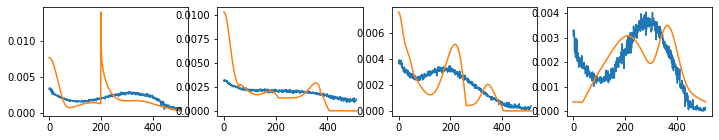

 epoch 2
   train loss: 0.000586234, mse: 0.000259457
   valid loss: 0.000522721, mse:0.000020994


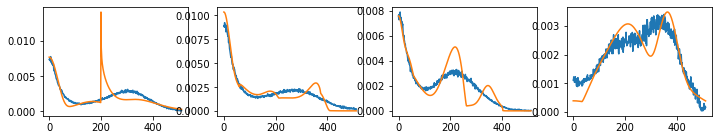

 epoch 3
   train loss: 0.000496864, mse: 0.000197583
   valid loss: 0.000472830, mse:0.000017852


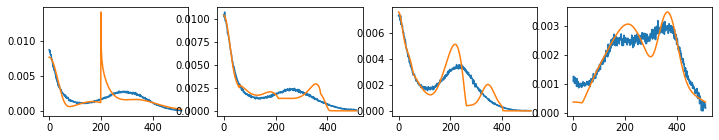

 epoch 4
   train loss: 0.000460385, mse: 0.000178095
   valid loss: 0.000456091, mse:0.000017094


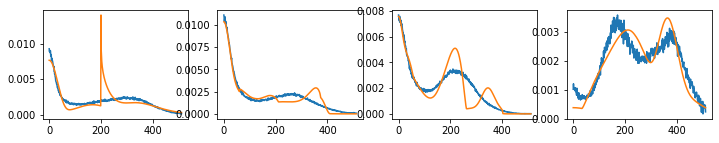

 epoch 5
   train loss: 0.000443454, mse: 0.000171100
   valid loss: 0.000437719, mse:0.000016408


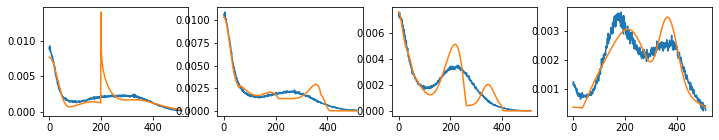

 epoch 6
   train loss: 0.000431959, mse: 0.000166241
   valid loss: 0.000426108, mse:0.000015883


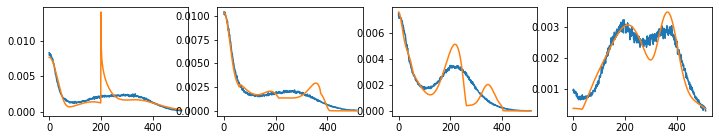

 epoch 7
   train loss: 0.000421538, mse: 0.000161818
   valid loss: 0.000420553, mse:0.000015626


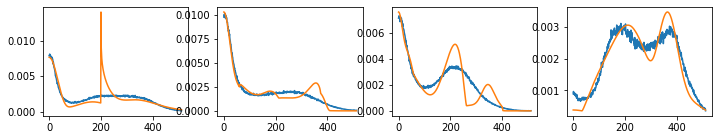

 epoch 8
   train loss: 0.000415138, mse: 0.000159067
   valid loss: 0.000410795, mse:0.000015404


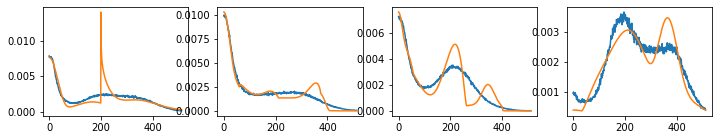

 epoch 9
   train loss: 0.000406776, mse: 0.000154867
   valid loss: 0.000409014, mse:0.000015173


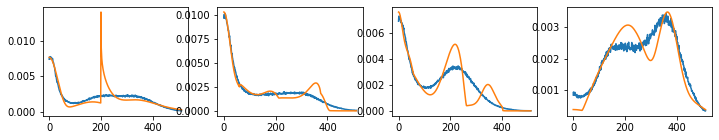

 epoch 10
   train loss: 0.000397228, mse: 0.000151583
   valid loss: 0.000393386, mse:0.000014398


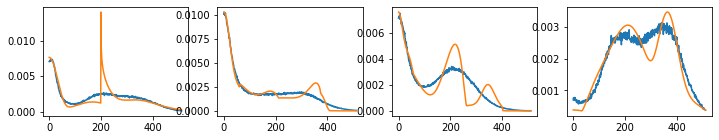

 epoch 11
   train loss: 0.000389795, mse: 0.000148039
   valid loss: 0.000385550, mse:0.000014136


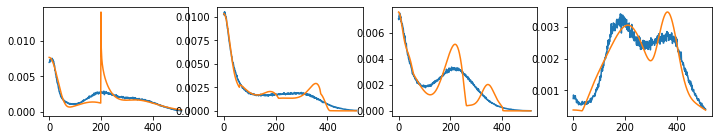

 epoch 12
   train loss: 0.000381740, mse: 0.000144936
   valid loss: 0.000379184, mse:0.000013874


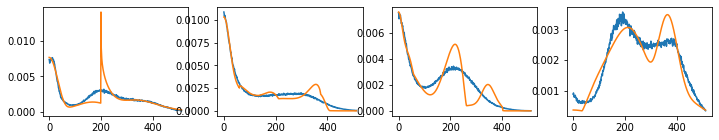

 epoch 13
   train loss: 0.000376792, mse: 0.000143007
   valid loss: 0.000384038, mse:0.000014119


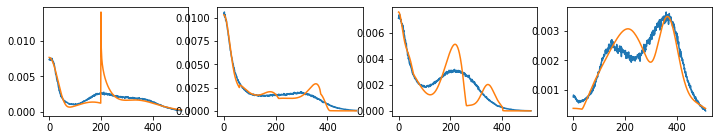

 epoch 14
   train loss: 0.000370293, mse: 0.000140448
   valid loss: 0.000372739, mse:0.000013464


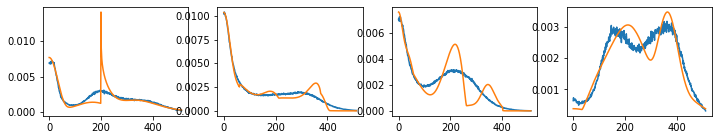

 epoch 15
   train loss: 0.000365951, mse: 0.000138743
   valid loss: 0.000362973, mse:0.000013215


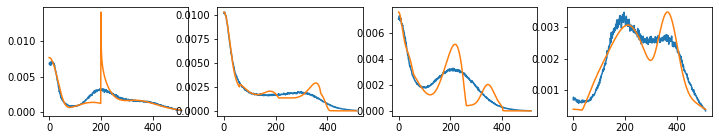

 epoch 16
   train loss: 0.000360250, mse: 0.000136617
   valid loss: 0.000361296, mse:0.000013171


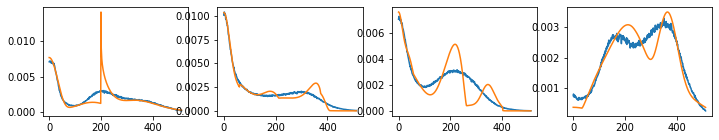

 epoch 17
   train loss: 0.000357424, mse: 0.000135269
   valid loss: 0.000355787, mse:0.000012953


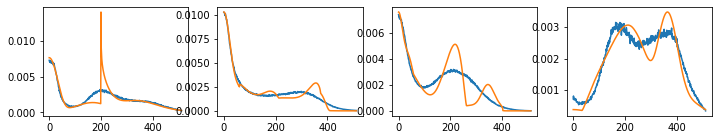

 epoch 18
   train loss: 0.000353937, mse: 0.000133992
   valid loss: 0.000358759, mse:0.000013041


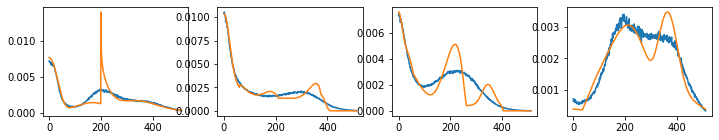

 epoch 19
   train loss: 0.000349979, mse: 0.000132691
   valid loss: 0.000355997, mse:0.000013066


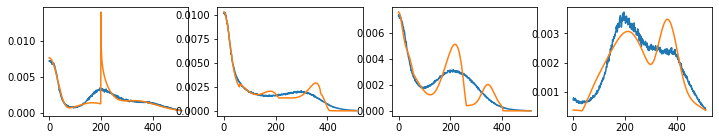

 epoch 20
   train loss: 0.000345570, mse: 0.000131189
   valid loss: 0.000341900, mse:0.000012483


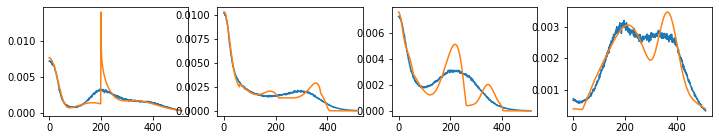

 epoch 21
   train loss: 0.000343779, mse: 0.000130219
   valid loss: 0.000345489, mse:0.000012541


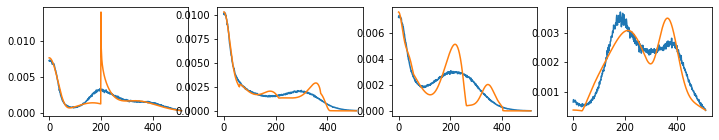

 epoch 22
   train loss: 0.000341187, mse: 0.000129252
   valid loss: 0.000346333, mse:0.000012468


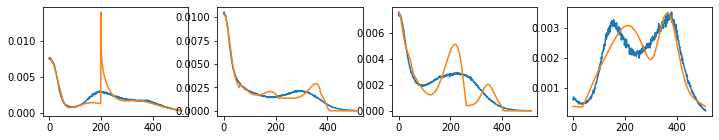

 epoch 23


KeyboardInterrupt: 

In [10]:
n_epochs = 200
early_stop_count = 40
best_valid_loss = TORCH_MAX
for epoch in range(1, n_epochs+1):
    print(f' epoch {epoch}')
    avg_train_loss = 0
    avg_train_mse = 0

    model.train()
    for batch_number, (inputs, targets) in enumerate(train_loader):
        
        # learning rate warmup
        if epoch == 1: 
            tmp_lr = (batch_number+1)*lr/len(train_loader)
            for g in optimizer.param_groups:
                g['lr'] = tmp_lr

        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        mse = mse_function(outputs, targets)
        avg_train_mse += mse.item()
        avg_train_loss += loss.item()
    
    avg_train_loss = avg_train_loss/len(train_loader)
    print(f'   train loss: {avg_train_loss:.9f}, mse: {avg_train_mse:.9f}')

    model.eval()
    avg_valid_loss = 0
    avg_valid_mse = 0
    for batch_number, (inputs, targets) in enumerate(valid_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        mse = mse_function(outputs, targets)
        avg_valid_loss += loss.item()
        avg_valid_mse += mse.item()

    avg_valid_loss = avg_valid_loss/len(valid_loader)
    print(f'   valid loss: {avg_valid_loss:.9f}, mse:{avg_valid_mse:.9f}')
    
    # plot a few validation spectra
    offset = 10
    n_plots = 4
    _, ax = plt.subplots(1,n_plots, figsize=(12,2))
    for i in range(n_plots):
        ax[i].plot(outputs[i+offset].detach().numpy())
        ax[i].plot(targets[i+offset].detach().numpy())
    plt.pause(0.001)
    
    scheduler.step(avg_train_loss)
    early_stop_count -= 1
    if avg_valid_loss < best_valid_loss:
        early_stop_count = 40
        best_valid_loss = avg_valid_loss
        best_epoch = epoch
        best_model = deepcopy(model)
        
    if early_stop_count == 0:
        print('early stopping limit reached!!')
        print(f'best epoch was {best_epoch}')
        break

## Saving the best model

In [11]:
torch.save(best_model.state_dict(), "best_model.pt")

## Loading the model

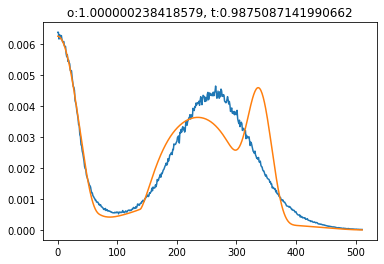

In [12]:
loaded_model = MLP().to(device)
loaded_model.load_state_dict(torch.load("best_model.pt", map_location=device))

outputs = loaded_model(inputs)
i = np.random.randint(0,64)
plt.plot(outputs[i].detach().numpy())
plt.plot(targets[i].detach().numpy())
plt.title(f"o:{outputs[0].sum().detach().numpy()}, t:{targets[0].sum().detach().numpy()}")
plt.show()